# CS6700: Reinforcement Learning
## Programming Assignment 1

Submitted by:
- Archish S (ME20B032)
- Vinayak Gupta (EE20B152)

# Monte Carlo REINFORCE

## Imports

In [1]:
import random
from dataclasses import dataclass
from collections import deque
from itertools import count

import gym
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],
#     "font.size": 10
# })
%config InlineBackend.figure_format = 'retina'

import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Networks

In [2]:
class PolicyNetwork(nn.Module):

    def __init__(self, state_size, action_size, hidden_size, args):
        super(PolicyNetwork, self).__init__()
        self.args = args
        
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4*hidden_size),
            nn.ReLU(),
            nn.Linear(4*hidden_size, action_size)
        )

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.fc(x)
    
    def select_action(self, state):
        with torch.no_grad():
            action = self.forward(state)
            action = F.softmax(action, dim=-1)
            m = Categorical(action)
            action = m.sample()
        return action, m.log_prob(action).requires_grad_(True)

In [3]:
class ValueNetwork(nn.Module):

    def __init__(self, state_size, hidden_size, args):
        super(ValueNetwork, self).__init__()
        self.args = args
        
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4*hidden_size),
            nn.ReLU(),
            nn.Linear(4*hidden_size, 1)
        )

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        return self.fc(x)

In [4]:
class Agent:
    def __init__(self, args, type):
        self.args = args
        self.args.type = type
        self.env = gym.make(args.env + '-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.policy = PolicyNetwork(self.state_size, self.action_size, args.hidden_size, self.args).to(self.args.device)
        self.init_policy_weights = self.policy.state_dict().copy()
        self.value = ValueNetwork(self.state_size, args.hidden_size, self.args).to(self.args.device)
        self.init_value_weights = self.value.state_dict().copy()

        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=self.args.lr)
        self.optimizer_value = optim.Adam(self.value.parameters(), lr=self.args.lr)

    def learn(self, batch):
        batch_state, batch_reward = zip(*batch)
        batch_state = torch.stack(batch_state, dim=0).float().to(self.args.device)
        
        G = []
        total = 0
        with torch.no_grad():
            for r in batch_reward[::-1]:
                total = r + self.args.gamma * total
                G.insert(0, total)
            G = torch.tensor(G, dtype=torch.float32).to(self.args.device)
            G = (G - G.mean()) / (G.std() + 1e-8)
            G = G.unsqueeze(1)

        self.policy.train()
        self.value.train()

        _, batch_log_prob = self.policy.select_action(batch_state)
        if self.args.type == 'wbaseline':
            value = self.value(batch_state)
            loss_value = F.mse_loss(value, G)
            self.optimizer_value.zero_grad()
            loss_value.backward()
            self.optimizer_value.step()

            deltas = G - value.detach()
            loss_policy = (-batch_log_prob * deltas).sum()
        elif self.args.type == 'wobaseline':
            deltas = G
            loss_policy = (-batch_log_prob * deltas).sum()
        
        self.value.eval()
        self.optimizer_policy.zero_grad()
        loss_policy.backward()
        self.optimizer_policy.step()

    def train(self):
        run_rewards = []    
        for run in tqdm.trange(self.args.num_runs, desc='Runs'):
            self.policy.init_weights()
            self.value.init_weights()
            self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=self.args.lr)
            self.optimizer_value = optim.Adam(self.value.parameters(), lr=self.args.lr)

            self.policy.train()
            if self.args.type == 'wbaseline':
                self.value.train()
            elif self.args.type == 'wobaseline':
                self.value.eval()
            else:
                raise NotImplementedError(f'Unknown type: {self.args.type}')

            episode_rewards = []
            for episode in tqdm.trange(self.args.num_episodes, desc='Episodes', leave=False):
                state = self.env.reset()
                total_reward = 0
                trajectory = []

                self.policy.eval()
                for t in count():
                    state = torch.tensor(state, dtype=torch.float32).to(self.args.device).unsqueeze(0)
                    action, _ = self.policy.select_action(state)
                    next_state, reward, done, _ = self.env.step(action.item())

                    total_reward = total_reward * self.args.gamma + reward
                    trajectory.append((state.flatten(), reward))

                    if done or t > self.args.max_steps:
                        break        
                    state = next_state

                episode_rewards.append(total_reward)

                # if np.mean(episode_rewards) > self.args.threshold:
                #     break
                self.learn(trajectory)

            run_rewards.append(episode_rewards)
        return run_rewards
            

## Simulation

In [5]:
@dataclass
class Args:
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    seed: int = 32 + 152

    env: str = ''
    algorithm: str = 'MCReinforce'
    type: str = ''

    gamma: float = 0.99
    lr: float = 1e-4
    num_runs: int = 5
    num_episodes: int = 1000
    max_steps: int = 500

    hidden_size: int = 32 if env == 'CartPole' else 64

# hidden_sizes = [32, 48, 64]

---

In [6]:
args = Args()
args.env = 'CartPole'

set_seed(args.seed)
agent = Agent(args, 'wobaseline')
cartpole_rewards_type1 = agent.train()

set_seed(args.seed)
agent = Agent(args, 'wbaseline')
cartpole_rewards_type2 = agent.train()

Runs: 100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


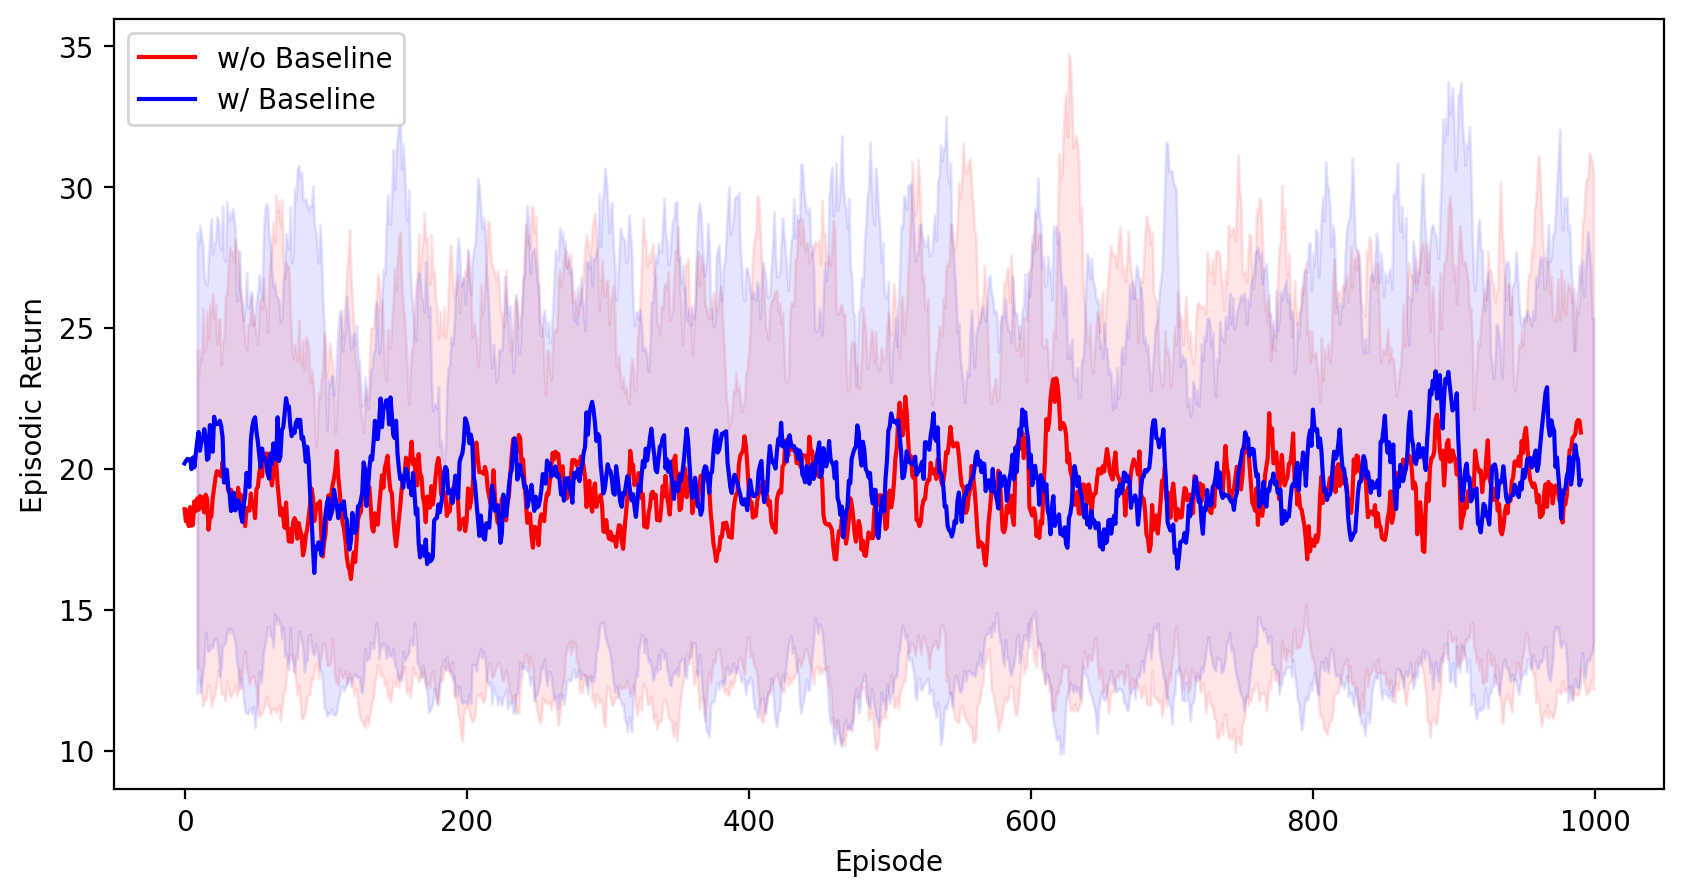

In [7]:
window_size = 10
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

type1_mean = np.mean(cartpole_rewards_type1, axis=0)
type1_std = np.std(cartpole_rewards_type1, axis=0)

ax.plot(np.convolve(type1_mean, np.ones(window_size)/window_size, mode='valid'), label='w/o Baseline', color='red')
ax.fill_between(range(window_size-1, len(type1_mean)), 
                np.convolve(type1_mean - type1_std, np.ones(window_size)/window_size, mode='valid'), 
                np.convolve(type1_mean + type1_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='red')

type2_mean = np.mean(cartpole_rewards_type2, axis=0)
type2_std = np.std(cartpole_rewards_type2, axis=0)

ax.plot(np.convolve(type2_mean, np.ones(window_size)/window_size, mode='valid'), label='w/ Baseline', color='blue')
ax.fill_between(range(window_size-1, len(type2_mean)), 
                np.convolve(type2_mean - type2_std, np.ones(window_size)/window_size, mode='valid'), 
                np.convolve(type2_mean + type2_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='blue')

ax.set_xlabel('Episode')
ax.set_ylabel('Episodic Return')
ax.legend(loc='upper left')
fig.savefig(f'result/cartpole_{args.algorithm}.pdf', bbox_inches='tight')

In [8]:
args = Args()
args.env = 'Acrobot'

set_seed(args.seed)
agent = Agent(args, 'wobaseline')
actobot_rewards_type1 = agent.train()

set_seed(args.seed)
agent = Agent(args, 'wbaseline')
actobot_rewards_type2 = agent.train()

Runs: 100%|██████████| 5/5 [07:17<00:00, 87.52s/it]


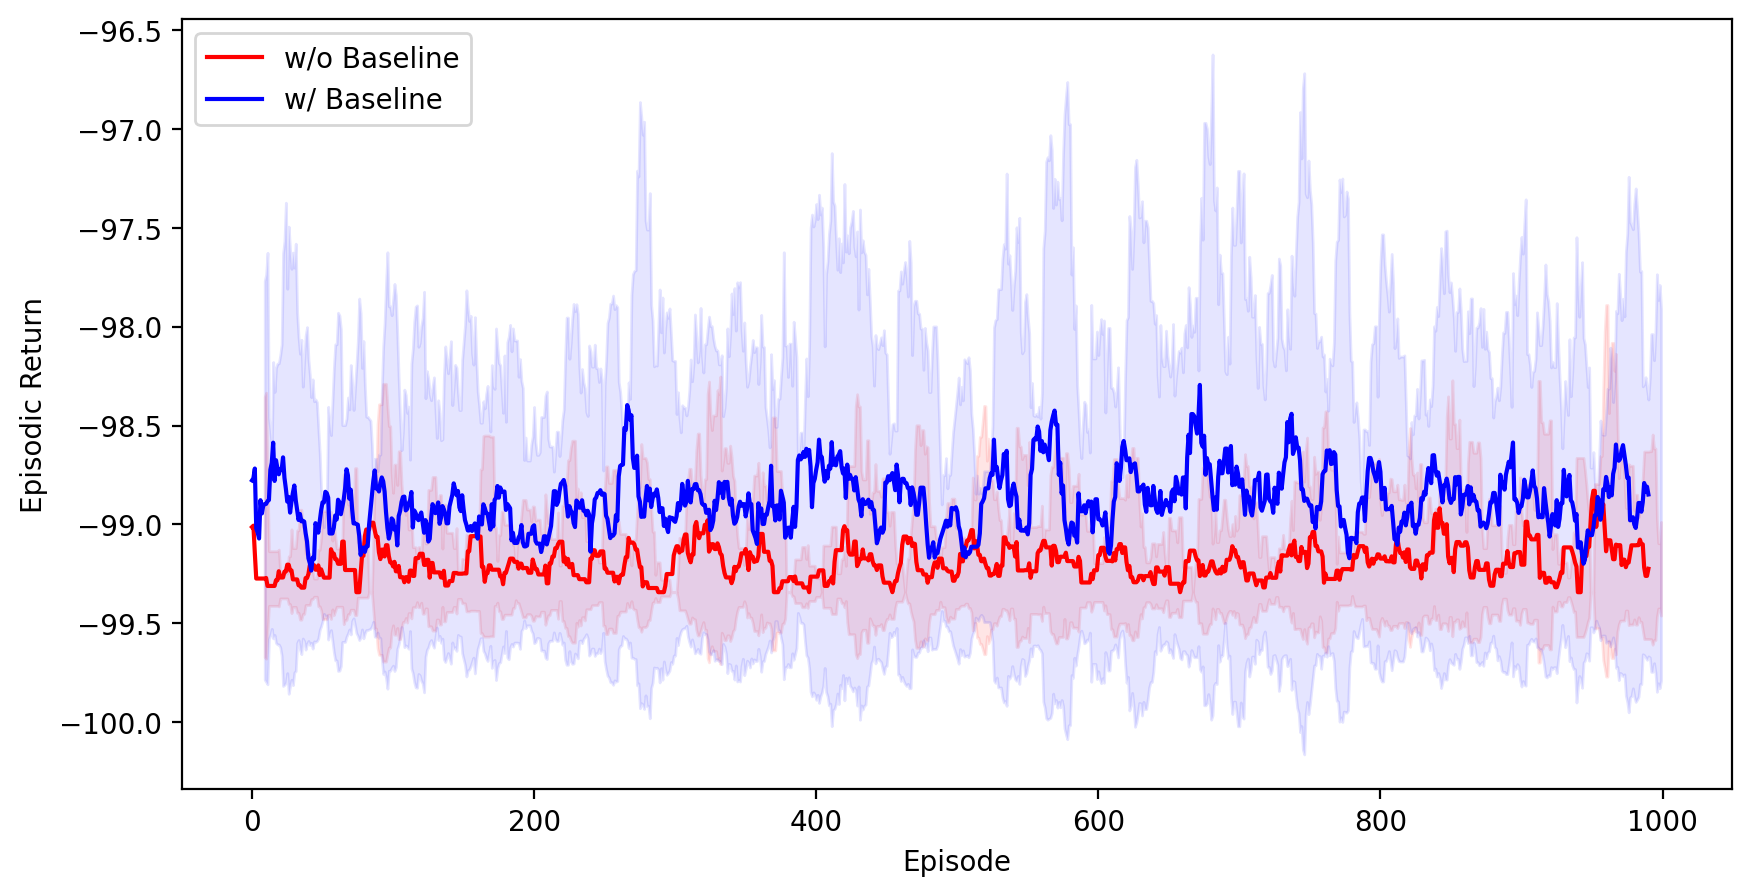

In [9]:
window_size = 10
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

type1_mean = np.mean(actobot_rewards_type1, axis=0)
type1_std = np.std(actobot_rewards_type1, axis=0)

ax.plot(np.convolve(type1_mean, np.ones(window_size)/window_size, mode='valid'), label='w/o Baseline', color='red')
ax.fill_between(range(window_size-1, len(type1_mean)), 
                np.convolve(type1_mean - type1_std, np.ones(window_size)/window_size, mode='valid'), 
                np.convolve(type1_mean + type1_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='red')

type2_mean = np.mean(actobot_rewards_type2, axis=0)
type2_std = np.std(actobot_rewards_type2, axis=0)

ax.plot(np.convolve(type2_mean, np.ones(window_size)/window_size, mode='valid'), label='w/ Baseline', color='blue')
ax.fill_between(range(window_size-1, len(type2_mean)), 
                np.convolve(type2_mean - type2_std, np.ones(window_size)/window_size, mode='valid'), 
                np.convolve(type2_mean + type2_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='blue')

ax.set_xlabel('Episode')
ax.set_ylabel('Episodic Return')
ax.legend(loc='upper left')
fig.savefig(f'result/acrobot_{args.algorithm}.pdf', bbox_inches='tight')

---

In [10]:
# log = pd.DataFrame(columns = ['environment', 'type', 'average_reward', 'hidden_size', 'reward_array'])

In [11]:
# for hidden_size in hidden_sizes:
#     args = Args()
#     args.env = 'CartPole'
#     args.hidden_size = hidden_size

#     set_seed(args.seed)
#     agent = Agent(args, 'wobaseline')
#     rewards = agent.train()

#     store = {
#         'environment': args.env,
#         'type': 'wobaseline',
#         'average_reward': np.mean(rewards),
#         'hidden_size': args.hidden_size,
#         # 'reward_array': rewards,
#     }
#     log = pd.concat([log, pd.DataFrame(store, index=[0])])

#     set_seed(args.seed)
#     agent = Agent(args, 'wbaseline')
#     rewards = agent.train()

#     store = {
#         'environment': args.env,
#         'type': 'wbaseline',
#         'average_reward': np.mean(rewards),
#         'hidden_size': args.hidden_size,
#         # 'reward_array': rewards,
#     }
#     log = pd.concat([log, pd.DataFrame(store, index=[0])])
    
#     log.to_csv('result/mcreinforce.csv', index=False)

In [12]:
# for hidden_size in hidden_sizes:
#     args = Args()
#     args.env = 'Acrobot'
#     args.hidden_size = hidden_size

#     set_seed(args.seed)
#     agent = Agent(args, 'wobaseline')
#     rewards = agent.train()

#     store = {
#         'environment': args.env,
#         'type': 'wobaseline',
#         'average_reward': np.mean(rewards),
#         'hidden_size': args.hidden_size,
#         # 'reward_array': rewards,
#     }
#     log = pd.concat([log, pd.DataFrame(store, index=[0])])

#     set_seed(args.seed)
#     agent = Agent(args, 'wbaseline')
#     rewards = agent.train()

#     store = {
#         'environment': args.env,
#         'type': 'wbaseline',
#         'average_reward': np.mean(rewards),
#         'hidden_size': args.hidden_size,
#         # 'reward_array': rewards,
#     }
#     log = pd.concat([log, pd.DataFrame(store, index=[0])])
    
#     log.to_csv('result/mcreinforce.csv', index=False)

In [13]:
# log.to_csv('result/mcreinforce.csv', index=False)

---